In [ ]:
!pip3 install --user seaborn

In [1]:
# Must be included at the beginning of each new notebook. 
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('satisfaction').getOrCreate()
#build spark context
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("satisfaction").setMaster("local")
sc = SparkContext.getOrCreate(conf)

In [2]:
# Importing data which has a header. Schema is automatically configured.
sdata = spark.read.csv('Dataset/satisfaction.csv',
                       header=True, inferSchema=True)

# Data Exploration

In [7]:
#describle the size of data
print((sdata.count(), len(sdata.columns)))

sdata.dtypes

(129880, 24)


[('id', 'int'),
 ('satisfaction', 'int'),
 ('Gender', 'string'),
 ('Customer Type', 'string'),
 ('Age', 'int'),
 ('Type of Travel', 'string'),
 ('Class', 'string'),
 ('Flight Distance', 'int'),
 ('Seat comfort', 'int'),
 ('Departure/Arrival time convenient', 'int'),
 ('Food and drink', 'int'),
 ('Gate location', 'int'),
 ('Inflight wifi service', 'int'),
 ('Inflight entertainment', 'int'),
 ('Online support', 'int'),
 ('Ease of Online booking', 'int'),
 ('On-board service', 'int'),
 ('Leg room service', 'int'),
 ('Baggage handling', 'int'),
 ('Checkin service', 'int'),
 ('Cleanliness', 'int'),
 ('Online boarding', 'int'),
 ('Departure Delay in Minutes', 'int'),
 ('Arrival Delay in Minutes', 'int')]

In [8]:
sdata.show(3)

+------+------------+------+--------------+---+---------------+--------+---------------+------------+---------------------------------+--------------+-------------+---------------------+----------------------+--------------+----------------------+----------------+----------------+----------------+---------------+-----------+---------------+--------------------------+------------------------+
|    id|satisfaction|Gender| Customer Type|Age| Type of Travel|   Class|Flight Distance|Seat comfort|Departure/Arrival time convenient|Food and drink|Gate location|Inflight wifi service|Inflight entertainment|Online support|Ease of Online booking|On-board service|Leg room service|Baggage handling|Checkin service|Cleanliness|Online boarding|Departure Delay in Minutes|Arrival Delay in Minutes|
+------+------------+------+--------------+---+---------------+--------+---------------+------------+---------------------------------+--------------+-------------+---------------------+----------------------+-

In [5]:
sdata.head(1)

[Row(id=11112, satisfaction=1, Gender='Female', Customer Type='Loyal Customer', Age=65, Type of Travel='Personal Travel', Class='Eco', Flight Distance=265, Seat comfort=0, Departure/Arrival time convenient=0, Food and drink=0, Gate location=2, Inflight wifi service=2, Inflight entertainment=4, Online support=2, Ease of Online booking=3, On-board service=3, Leg room service=0, Baggage handling=3, Checkin service=5, Cleanliness=3, Online boarding=2, Departure Delay in Minutes=0, Arrival Delay in Minutes=0)]

In [9]:
#the summary information of some fields
sdata.describe('Seat comfort','Age','Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes').show()

+-------+-----------------+------------------+------------------+--------------------------+------------------------+
|summary|     Seat comfort|               Age|   Flight Distance|Departure Delay in Minutes|Arrival Delay in Minutes|
+-------+-----------------+------------------+------------------+--------------------------+------------------------+
|  count|           129880|            129880|            129880|                    129880|                  129487|
|   mean|2.838597166615337| 39.42795657530028| 1981.409054511857|        14.713712657838004|       15.09112883918849|
| stddev|1.392983243269906|15.119359950371587|1027.1156056133927|         38.07112621503625|      38.465650240119146|
|    min|                0|                 7|                50|                         0|                       0|
|    max|                5|                85|              6951|                      1592|                    1584|
+-------+-----------------+------------------+----------

In [10]:
#the number of values in satisfaction field
sdata.groupby('satisfaction').count().show()

+------------+-----+
|satisfaction|count|
+------------+-----+
|           1|71087|
|           0|58793|
+------------+-----+



In [11]:
#the number of values in Inflight entertainment field
sdata.groupby('Inflight entertainment').count().show()

+----------------------+-----+
|Inflight entertainment|count|
+----------------------+-----+
|                     1|11809|
|                     3|24200|
|                     5|29831|
|                     4|41879|
|                     2|19183|
|                     0| 2978|
+----------------------+-----+



In [12]:
#the number of values in Seat comfort field
sdata.groupby('Seat comfort').count().show()

+------------+-----+
|Seat comfort|count|
+------------+-----+
|           1|20949|
|           3|29183|
|           5|17827|
|           4|28398|
|           2|28726|
|           0| 4797|
+------------+-----+



In [13]:
#the distribution of satisfaction according to Inflight entertainment field
sdata.crosstab('satisfaction', 'Inflight entertainment').show()

+-----------------------------------+----+----+-----+-----+-----+-----+
|satisfaction_Inflight entertainment|   0|   1|    2|    3|    4|    5|
+-----------------------------------+----+----+-----+-----+-----+-----+
|                                  1|1966|2484| 3271| 4815|30150|28401|
|                                  0|1012|9325|15912|19385|11729| 1430|
+-----------------------------------+----+----+-----+-----+-----+-----+



In [14]:
#the distribution of satisfaction according to Seat comfort field
sdata.crosstab('satisfaction', 'Seat comfort').show()

+-------------------------+----+-----+-----+-----+-----+-----+
|satisfaction_Seat comfort|   0|    1|    2|    3|    4|    5|
+-------------------------+----+-----+-----+-----+-----+-----+
|                        1|4787| 9446|10272|10389|18507|17686|
|                        0|  10|11503|18454|18794| 9891|  141|
+-------------------------+----+-----+-----+-----+-----+-----+



# Verifying Data Quality

In [16]:
from pyspark.sql.functions import col

sdata.describe().filter(col("summary") == "count").show()

+-------+------+------------+------+-------------+------+--------------+------+---------------+------------+---------------------------------+--------------+-------------+---------------------+----------------------+--------------+----------------------+----------------+----------------+----------------+---------------+-----------+---------------+--------------------------+------------------------+
|summary|    id|satisfaction|Gender|Customer Type|   Age|Type of Travel| Class|Flight Distance|Seat comfort|Departure/Arrival time convenient|Food and drink|Gate location|Inflight wifi service|Inflight entertainment|Online support|Ease of Online booking|On-board service|Leg room service|Baggage handling|Checkin service|Cleanliness|Online boarding|Departure Delay in Minutes|Arrival Delay in Minutes|
+-------+------+------------+------+-------------+------+--------------+------+---------------+------------+---------------------------------+--------------+-------------+---------------------+---

In [17]:
#count null values
nullCount = sdata.where(sdata['Arrival Delay in Minutes'].isNull()).count()
print('The number of null value is: ' + str(nullCount))

The number of null value is: 393


In [18]:
#count duplicate values
num = sdata.count() - sdata.select('id').distinct().count()
print('The number of duplicate value is: ' + str(num))

The number of duplicate value is: 0


# Data selection

In [3]:
#drop irrelevant columns
sdata = sdata.drop('id','Gender','Customer Type','Age',
                   'Type of Travel','Class','Flight Distance',
                   'Departure Delay in Minutes','Arrival Delay in Minutes')

In [20]:
sdata.printSchema()

root
 |-- satisfaction: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- Online support: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)



In [4]:
from pyspark.sql import functions as f
#group values in key attributes 
sdata = sdata.withColumn('Seat comfort',f.when(f.col('Seat comfort') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('Departure/Arrival time convenient',
                          f.when(f.col('Departure/Arrival time convenient') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('Food and drink',f.when(f.col('Food and drink') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('Gate location',f.when(f.col('Gate location') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('Inflight wifi service',f.when(f.col('Inflight wifi service') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('Inflight entertainment',f.when(f.col('Inflight entertainment') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('Online support',f.when(f.col('Online support') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('Ease of Online booking',f.when(f.col('Ease of Online booking') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('On-board service',f.when(f.col('On-board service') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('Leg room service',f.when(f.col('Leg room service') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('Baggage handling',f.when(f.col('Baggage handling') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('Checkin service',f.when(f.col('Checkin service') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('Cleanliness',f.when(f.col('Cleanliness') <=3, 'low').otherwise('high'))
sdata = sdata.withColumn('Online boarding',f.when(f.col('Online boarding') <=3, 'low').otherwise('high'))
#show the group results
sdata.groupby('Seat comfort').count().show()
sdata.groupby('Food and drink').count().show()
sdata.groupby('Online boarding').count().show()

+------------+-----+
|Seat comfort|count|
+------------+-----+
|         low|83655|
|        high|46225|
+------------+-----+

+--------------+-----+
|Food and drink|count|
+--------------+-----+
|           low|82317|
|          high|47563|
+--------------+-----+

+---------------+-----+
|Online boarding|count|
+---------------+-----+
|            low|64726|
|           high|65154|
+---------------+-----+



# Data Integration

In [5]:
# Importing data which has a header. Schema is automatically configured.
sdata2015 = spark.read.csv('Dataset/satisfaction_2015.csv',
                           header=True, inferSchema=True)
sdata2015.printSchema()

root
 |-- id: integer (nullable = true)
 |-- satisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- Online support: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Online

In [6]:
#drop columns
sdata2015 = sdata2015.drop('id','Gender','Customer Type','Age',
                   'Type of Travel','Class','Flight Distance',
                   'Departure Delay in Minutes','Arrival Delay in Minutes')

In [7]:
#group values in key attributes 
sdata2015 = sdata2015.withColumn('Seat comfort',
                                 f.when(f.col('Seat comfort')<=3, 'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('Departure/Arrival time convenient',
                                  f.when(f.col('Departure/Arrival time convenient')<=3,'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('Food and drink',
                                 f.when(f.col('Food and drink') <=3, 'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('Gate location',
                                 f.when(f.col('Gate location') <=3, 'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('Inflight wifi service',
                                 f.when(f.col('Inflight wifi service') <=3, 'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('Inflight entertainment',
                                 f.when(f.col('Inflight entertainment') <=3, 'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('Online support',
                                 f.when(f.col('Online support') <=3, 'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('Ease of Online booking',
                                 f.when(f.col('Ease of Online booking') <=3, 'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('On-board service',
                                 f.when(f.col('On-board service') <=3, 'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('Leg room service',
                                 f.when(f.col('Leg room service') <=3, 'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('Baggage handling',
                                 f.when(f.col('Baggage handling') <=3, 'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('Checkin service',
                                 f.when(f.col('Checkin service') <=3, 'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('Cleanliness',
                                 f.when(f.col('Cleanliness') <=3, 'low').otherwise('high'))
sdata2015 = sdata2015.withColumn('Online boarding',
                                 f.when(f.col('Online boarding') <=3, 'low').otherwise('high'))

In [8]:
#merge two data sets
sdataTotal = sdata.union(sdata2015)
#show the total number of records
print('The total number of records is:' + str(sdataTotal.count()))

The total number of records is:259760


# Formating Data

In [26]:
sdataTotal.printSchema()

root
 |-- satisfaction: integer (nullable = true)
 |-- Seat comfort: string (nullable = false)
 |-- Departure/Arrival time convenient: string (nullable = false)
 |-- Food and drink: string (nullable = false)
 |-- Gate location: string (nullable = false)
 |-- Inflight wifi service: string (nullable = false)
 |-- Inflight entertainment: string (nullable = false)
 |-- Online support: string (nullable = false)
 |-- Ease of Online booking: string (nullable = false)
 |-- On-board service: string (nullable = false)
 |-- Leg room service: string (nullable = false)
 |-- Baggage handling: string (nullable = false)
 |-- Checkin service: string (nullable = false)
 |-- Cleanliness: string (nullable = false)
 |-- Online boarding: string (nullable = false)



In [27]:
sdataTotal.select('satisfaction').show(5)

+------------+
|satisfaction|
+------------+
|           1|
|           1|
|           1|
|           1|
|           1|
+------------+
only showing top 5 rows



In [9]:
#group values of key attributes 
sdataTotal = sdataTotal.withColumn('Seat comfort',
                                 f.when(f.col('Seat comfort')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('Departure/Arrival time convenient',
                                  f.when(f.col('Departure/Arrival time convenient')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('Food and drink',
                                 f.when(f.col('Food and drink')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('Gate location',
                                 f.when(f.col('Gate location')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('Inflight wifi service',
                                 f.when(f.col('Inflight wifi service')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('Inflight entertainment',
                                 f.when(f.col('Inflight entertainment')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('Online support',
                                 f.when(f.col('Online support')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('Ease of Online booking',
                                 f.when(f.col('Ease of Online booking')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('On-board service',
                                 f.when(f.col('On-board service')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('Leg room service',
                                 f.when(f.col('Leg room service')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('Baggage handling',
                                 f.when(f.col('Baggage handling')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('Checkin service',
                                 f.when(f.col('Checkin service')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('Cleanliness',
                                 f.when(f.col('Cleanliness')=='low', 0).otherwise(1))
sdataTotal = sdataTotal.withColumn('Online boarding',
                                 f.when(f.col('Online boarding')=='low', 0).otherwise(1))

In [29]:
sdataTotal.printSchema()

root
 |-- satisfaction: integer (nullable = true)
 |-- Seat comfort: integer (nullable = false)
 |-- Departure/Arrival time convenient: integer (nullable = false)
 |-- Food and drink: integer (nullable = false)
 |-- Gate location: integer (nullable = false)
 |-- Inflight wifi service: integer (nullable = false)
 |-- Inflight entertainment: integer (nullable = false)
 |-- Online support: integer (nullable = false)
 |-- Ease of Online booking: integer (nullable = false)
 |-- On-board service: integer (nullable = false)
 |-- Leg room service: integer (nullable = false)
 |-- Baggage handling: integer (nullable = false)
 |-- Checkin service: integer (nullable = false)
 |-- Cleanliness: integer (nullable = false)
 |-- Online boarding: integer (nullable = false)



# Reducing Data

In [10]:
#import Statistics
from pyspark.mllib.stat import Statistics

#convert dataframe to rdd
sdataRdd = sdataTotal.rdd.map(lambda i: i[0:])
#calculate the correlation between columns
result = Statistics.corr(sdataRdd)

#show the first row of the correlation results
print(result[0])

[ 1.          0.33350747 -0.03652083  0.17755485  0.02634508  0.31166526
  0.50688262  0.33801023  0.36648668  0.32983659  0.3376179   0.27501067
  0.18120575  0.28403197  0.42902678]


In [12]:
sdataTotal.columns

['satisfaction',
 'Seat comfort',
 'Departure/Arrival time convenient',
 'Food and drink',
 'Gate location',
 'Inflight wifi service',
 'Inflight entertainment',
 'Online support',
 'Ease of Online booking',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Cleanliness',
 'Online boarding']

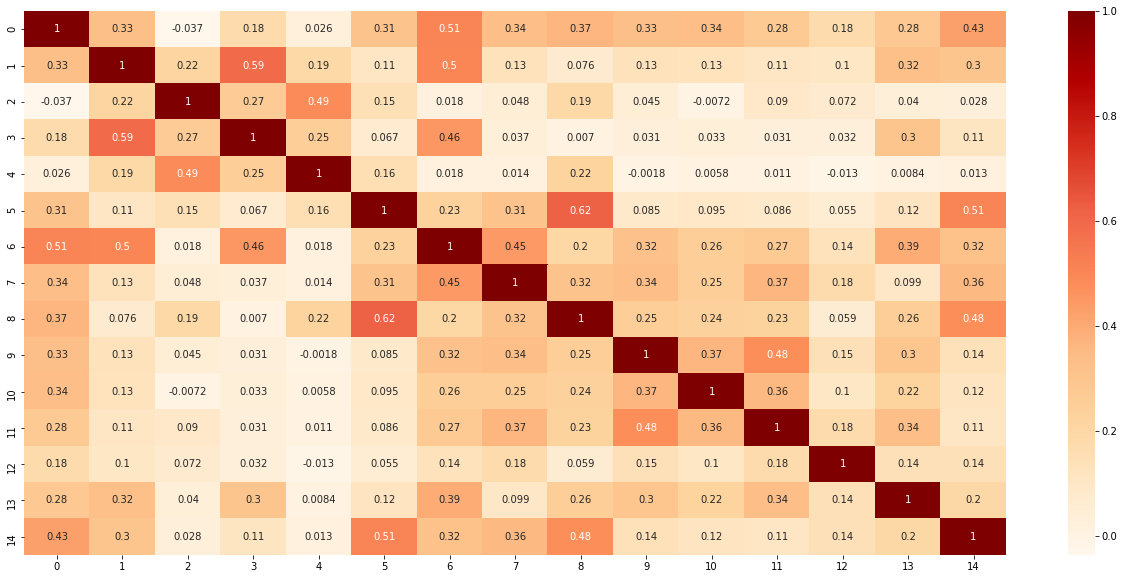

In [22]:
#draw heatmap of correlation
import seaborn as sns 
import matplotlib.pyplot as plt
plt.figure(figsize=(22,10))
sns.heatmap(result, cmap="OrRd", annot=True)

In [23]:
#drop columns
sdataTotal = sdataTotal.drop("Departure/Arrival time convenient")
sdataTotal = sdataTotal.drop("Food and drink")
sdataTotal = sdataTotal.drop("Gate location")
sdataTotal = sdataTotal.drop("Checkin service")

sdataTotal.columns

['satisfaction',
 'Seat comfort',
 'Inflight wifi service',
 'Inflight entertainment',
 'Online support',
 'Ease of Online booking',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Cleanliness',
 'Online boarding']

# Data Projection

In [24]:
#modify column name
sdataTotal = sdataTotal.withColumnRenamed("Seat comfort", "Seat_comfort")\
        .withColumnRenamed("Inflight wifi service", "Inflight_wifi_service")\
        .withColumnRenamed("Inflight entertainment", "Inflight_entertainment")\
        .withColumnRenamed("Online support", "Online_support")\
        .withColumnRenamed("Ease of Online booking", "Ease_of_Online_booking")\
        .withColumnRenamed("On-board service", "On-board_service")\
        .withColumnRenamed("Leg room service", "Leg_room_service")\
        .withColumnRenamed("Baggage handling", "Baggage_handling")\
        .withColumnRenamed("Cleanliness", "Cleanliness")\
        .withColumnRenamed("Online boarding", "Online_boarding")
sdataTotal.columns

['satisfaction',
 'Seat_comfort',
 'Inflight_wifi_service',
 'Inflight_entertainment',
 'Online_support',
 'Ease_of_Online_booking',
 'On-board_service',
 'Leg_room_service',
 'Baggage_handling',
 'Cleanliness',
 'Online_boarding']

In [37]:
#the number of values in satisfaction field
sdataTotal.groupby('satisfaction').count().show()

+------------+------+
|satisfaction| count|
+------------+------+
|           1|127515|
|           0|132245|
+------------+------+



# 6 Algorithms Selection

In [84]:
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Combine all features into one vector named features.
assembler = VectorAssembler(
  inputCols=['Seat_comfort',
             'Inflight_wifi_service',
             'Inflight_entertainment',
             'Online_support',
             'Ease_of_Online_booking',
             'On-board_service',
             'Leg_room_service',
             'Baggage_handling',
             'Cleanliness',
             'Online_boarding'],
              outputCol="features")

#transform the data. 
output = assembler.transform(sdataTotal)
#join features and target column
final_data = output.select("features",'satisfaction')
final_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- satisfaction: integer (nullable = true)



In [85]:
final_data = output.select("features",'satisfaction')
final_data.show()

+--------------------+------------+
|            features|satisfaction|
+--------------------+------------+
|      (10,[2],[1.0])|           1|
|(10,[5,6,7],[1.0,...|           1|
|(10,[7,8],[1.0,1.0])|           1|
|      (10,[2],[1.0])|           1|
|(10,[1,3,9],[1.0,...|           1|
|(10,[5,6,7,8],[1....|           1|
|[0.0,0.0,1.0,1.0,...|           1|
|(10,[7,8],[1.0,1.0])|           1|
|[0.0,1.0,0.0,1.0,...|           1|
|(10,[6,7,8],[1.0,...|           1|
|      (10,[9],[1.0])|           1|
|(10,[7,8],[1.0,1.0])|           1|
|(10,[1,3,4,8,9],[...|           1|
|(10,[1,3,4,6,9],[...|           1|
|(10,[1,4,5,7,8],[...|           1|
|      (10,[6],[1.0])|           1|
|[0.0,1.0,0.0,1.0,...|           1|
|          (10,[],[])|           1|
|          (10,[],[])|           1|
|      (10,[6],[1.0])|           1|
+--------------------+------------+
only showing top 20 rows



In [86]:
train_data,test_data = final_data.randomSplit([0.8,0.2])

print('-'*40)
print('The number of train set is ' + str(train_data.count()))
print('-'*40)
print('The number of train set is ' + str(test_data.count()))

----------------------------------------
The number of train set is 208048
----------------------------------------
The number of train set is 51712


In [41]:
# Let's see our training data.
train_data.describe().show()

# And our testing data.
test_data.describe().show()

+-------+------------------+
|summary|      satisfaction|
+-------+------------------+
|  count|            207952|
|   mean| 0.490584365622836|
| stddev|0.4999125399599821|
|    min|                 0|
|    max|                 1|
+-------+------------------+

+-------+------------------+
|summary|      satisfaction|
+-------+------------------+
|  count|             51808|
|   mean|0.4921440704138357|
| stddev|0.4999431055448151|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [43]:
#Compare several classification algorithms
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_evaluator = MulticlassClassificationEvaluator(labelCol="satisfaction")

#create a list to store algorithms
Algorithms = [ DecisionTreeClassifier(labelCol='satisfaction', featuresCol='features'),
              RandomForestClassifier(labelCol='satisfaction',featuresCol='features'),
              LogisticRegression(labelCol='satisfaction',featuresCol='features'), 
              NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol='satisfaction'),]
#create a list to store algorithm names and comparison results
list_name = ['DecisionTreeClassifier', 
             'RandomForestClassifier', 
             'LogisticRegression', 
             'NaiveBayes']
list_resu = []

row_index = 0
for algo in Algorithms:
 #loop display results       
    predictor = algo.fit(train_data).transform(test_data)
    acc = acc_evaluator.evaluate(predictor)
    print('-'*40)
    print(list_name[row_index] + ' has an accuracy of: {0:2.2f}%'.format(acc*100))
    list_resu.insert(row_index, round(acc, 4)*100)
    row_index += 1


----------------------------------------
DecisionTreeClassifier has an accuracy of: 82.97%
----------------------------------------
RandomForestClassifier has an accuracy of: 82.67%
----------------------------------------
LogisticRegression has an accuracy of: 78.92%
----------------------------------------
NaiveBayes has an accuracy of: 63.44%


Text(0,0.5,'Accuracy')

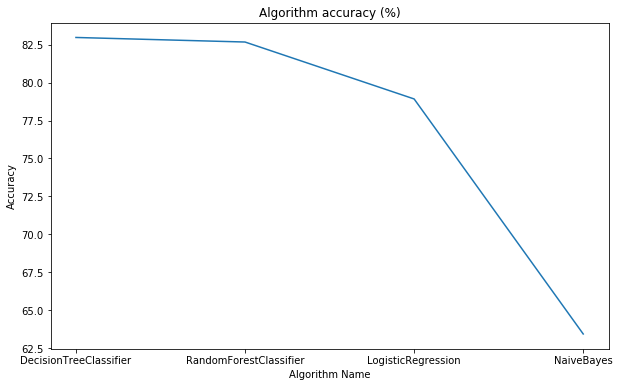

In [44]:
# multiple line plot
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 6))

plt.plot(list_name, list_resu)

# Add titles
plt.title("Algorithm accuracy (%)")
plt.xlabel("Algorithm Name")
plt.ylabel("Accuracy")


# Model Conduction

In [87]:
from pyspark.ml.classification import DecisionTreeClassifier

# Decision tree for classification
classifier = DecisionTreeClassifier(labelCol='satisfaction', 
                                    featuresCol='features',
                                    maxDepth=3)

# Train the model
model = classifier.fit(train_data)
model.extractParamMap

<bound method Params.extractParamMap of DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4deea73614f9423d21ea) of depth 3 with 15 nodes>

In [88]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictor = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="satisfaction", 
                                              predictionCol="prediction",
                                              metricName="accuracy")

accuracy = evaluator.evaluate(predictor)
print('-'*40)
print('The accuracy of Decision tree is: {0:2.2f}%'.format(accuracy*100))
print('-'*40)

----------------------------------------
The accuracy of Decision tree is: 81.77%
----------------------------------------


In [50]:
#extract feature importance
model.featureImportances

SparseVector(10, {0: 0.0736, 2: 0.5805, 4: 0.1514, 6: 0.028, 8: 0.0175, 9: 0.1491})

Text(0,0.5,'Importance')

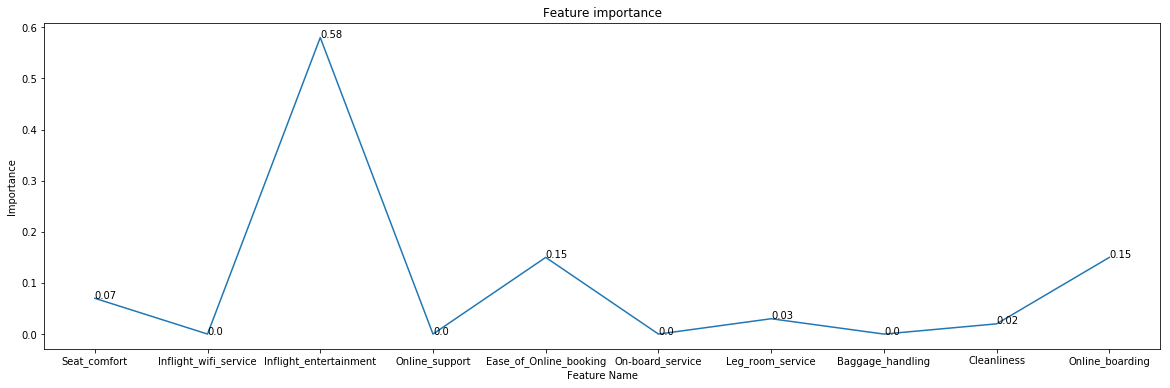

In [51]:
#feature importance
import numpy as np
import matplotlib.pyplot as plt 

feature_name = ['Seat_comfort', 'Inflight_wifi_service','Inflight_entertainment',
               'Online_support','Ease_of_Online_booking','On-board_service',
               'Leg_room_service', 'Baggage_handling','Cleanliness',
                'Online_boarding']
#round importance values
list_importance1 = np.array(model.featureImportances)
list_importance = [round(elem, 2) for elem in list_importance1]

# multiple line plot
plt.figure(figsize=(20, 6))
plt.plot(feature_name, list_importance)
for a,b in zip(feature_name, list_importance): 
    plt.text(a, b, str(b))
    
# Add titles
plt.title("Feature importance")
plt.xlabel("Feature Name")
plt.ylabel("Importance")

In [52]:
#print decision rules
print(model.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_40abbbb7bab41d75dd7c) of depth 3 with 15 nodes
  If (feature 2 <= 0.0)
   If (feature 0 <= 0.0)
    If (feature 4 <= 0.0)
     Predict: 0.0
    Else (feature 4 > 0.0)
     Predict: 0.0
   Else (feature 0 > 0.0)
    If (feature 8 <= 0.0)
     Predict: 0.0
    Else (feature 8 > 0.0)
     Predict: 1.0
  Else (feature 2 > 0.0)
   If (feature 9 <= 0.0)
    If (feature 4 <= 0.0)
     Predict: 0.0
    Else (feature 4 > 0.0)
     Predict: 1.0
   Else (feature 9 > 0.0)
    If (feature 6 <= 0.0)
     Predict: 1.0
    Else (feature 6 > 0.0)
     Predict: 1.0



In [53]:
#show feature name
feature_name = ['Seat_comfort','Inflight_wifi_service','Inflight_entertainment',
               'Online_support','Ease_of_Online_booking','On-board_service',
               'Leg_room_service', 'Baggage_handling','Cleanliness',
                'Online_boarding']

print('-'*40)
index = 0
for feature in feature_name:
    print('| feature ' + str(index) + ' is ' + feature_name[index])
    index += 1
print('-'*40)

----------------------------------------
| feature 0 is Seat_comfort
| feature 1 is Inflight_wifi_service
| feature 2 is Inflight_entertainment
| feature 3 is Online_support
| feature 4 is Ease_of_Online_booking
| feature 5 is On-board_service
| feature 6 is Leg_room_service
| feature 7 is Baggage_handling
| feature 8 is Cleanliness
| feature 9 is Online_boarding
----------------------------------------
